<a href="https://colab.research.google.com/github/muthonioprah/Maize-Crop-Disease-Detection-Using-Machine-Learning-and-Computer-Vision/blob/main/Copy_of_Copy_of_CNN_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Convolutional Neural Network
# Importing the libraries
import tensorflow as tf
# The module that will help us to do the image preprocessing
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers

#Importing matplotlib to see the images 
import matplotlib.pyplot as plt
%matplotlib inline
import os
from matplotlib.figure import Figure
from keras_preprocessing import image 
import cv2

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import imghdr

def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'/content/drive/Shareddrives/Group 1 /Maize Disease Dataset'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  Healthy Maize
processing class directory  Maize Gray leaf spot
processing class directory  Maize Common rust_
processing class directory  Maize streak disease
processing class directory  Maize northern leaf blight
processing class directory  Maize Head smut
 no improper image files were found


In [ ]:
#assigning our values to variables
batches = 32
image_size = 256
channels= 3
epochs=10

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/Shareddrives/Group 1 /Maize Disease Dataset',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256),
  batch_size=10)

Found 582 files belonging to 6 classes.
Using 466 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/Shareddrives/Group 1 /Maize Disease Dataset',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=10)

Found 582 files belonging to 6 classes.
Using 116 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Healthy Maize', 'Maize Common rust_', 'Maize Gray leaf spot', 'Maize Head smut', 'Maize northern leaf blight', 'Maize streak disease']


Visualize the data

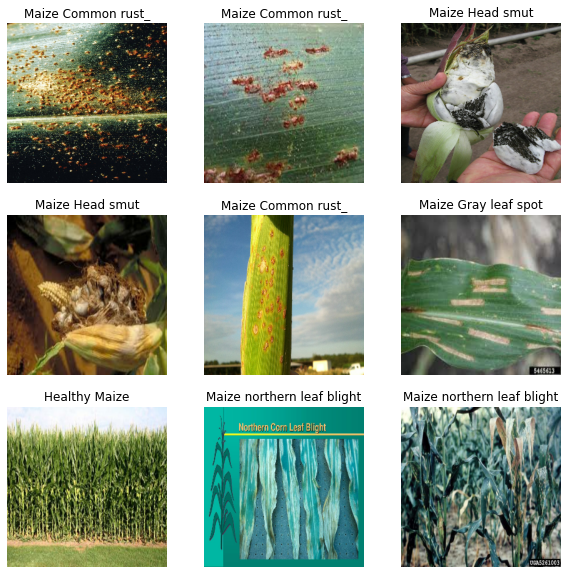

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 256, 256, 3)
(10,)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9997456


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 6

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=12
)

Epoch 1/12
47/47 [==============================] - 61s 1s/step - loss: 1.8084 - accuracy: 0.1631 - val_loss: 1.7511 - val_accuracy: 0.1724
Epoch 2/12
47/47 [==============================] - 2s 36ms/step - loss: 1.7231 - accuracy: 0.2897 - val_loss: 1.6499 - val_accuracy: 0.3190
Epoch 3/12
47/47 [==============================] - 2s 36ms/step - loss: 1.5880 - accuracy: 0.3777 - val_loss: 1.4858 - val_accuracy: 0.4483
Epoch 4/12
47/47 [==============================] - 2s 36ms/step - loss: 1.2119 - accuracy: 0.5601 - val_loss: 1.6778 - val_accuracy: 0.4224
Epoch 5/12
47/47 [==============================] - 2s 36ms/step - loss: 0.7746 - accuracy: 0.7361 - val_loss: 1.9108 - val_accuracy: 0.4397
Epoch 6/12
47/47 [==============================] - 2s 36ms/step - loss: 0.6549 - accuracy: 0.8047 - val_loss: 1.9210 - val_accuracy: 0.4224
Epoch 7/12
47/47 [==============================] - 2s 36ms/step - loss: 0.5176 - accuracy: 0.8755 - val_loss: 2.8979 - val_accuracy: 0.4397
Epoch 8/12
47/